# Movie Recommendation Project - Through Correlations With Liked Films And The Year Watching
In this project we will try to predict which movie should be your next movie, what makes our algorithm more interesting is that it takes into consideration the year you're are watching the movie as movie genres popularity is varying depending on the year.

Because of low-quality data on old movies, we will **not** ignore movies that were released after the year of watching parameter.

## Project outline

In order to achieve our goal we will be looking into to 2 datasets. IMDb's list of movies and MovieLens users rating.

- Analyzing IMDb's movies dataset to determine which movie genres are popular based on the year
- Analyzing MovieLens user rating dataset
- Determining which movie to recommened based on user rating alone
- Interfacing with the data analysis we did on the popularity of genres

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from scipy import *
import datetime
# from google.colab import files
from datetime import datetime
from dateutil.parser import parse

# IMDb

our relevant years are bewteen 1922 to 2014


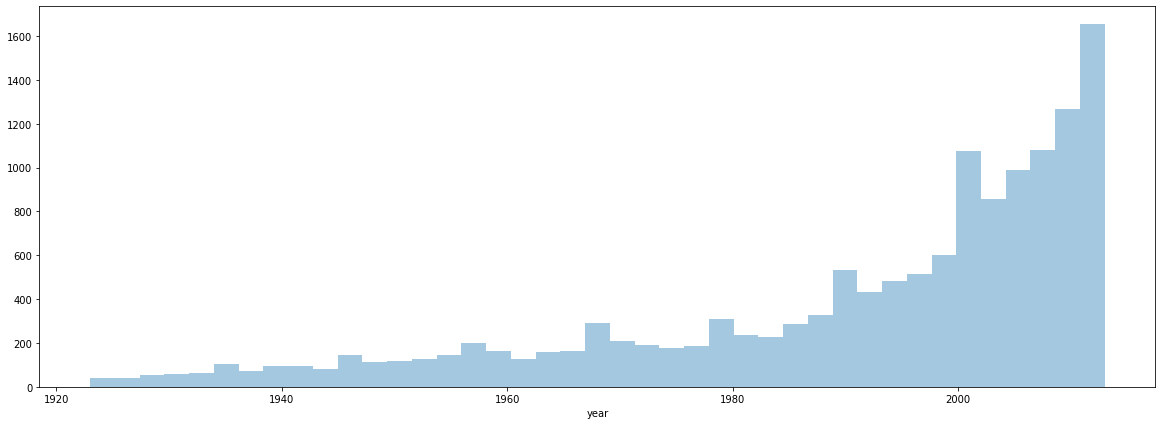

In [26]:
# loading imdb 
imdb_df = pd.read_csv('https://www.dropbox.com/s/e6qbgjyrlseh2is/imdb.csv?dl=1',error_bad_lines=False,warn_bad_lines=False)

# taking a look at anomlies, years where there is low number of movies
# finding the longest sequance of years with movie count higher then 10
groupby_year = imdb_df.groupby('year').size().reset_index(name='count').sort_values(['year'])
groupby_year['count'] = groupby_year['count'].apply(lambda x: x < 10)

groupby_year.reset_index(inplace=True)

groupby_year = groupby_year.groupby(groupby_year['count'].cumsum()).agg(
    {'year':['count', 'min', 'max']})

groupby_year.columns = groupby_year.columns.droplevel()

years_limit = groupby_year[groupby_year['count']==groupby_year['count'].max()]
print('our relevant years are bewteen {} to {}'.format(
    int(years_limit['min'].values),int(years_limit['max'].values))
)

# clean movies out of limit
imdb_df = imdb_df[(imdb_df['year'] > int(years_limit['min'].values)) & (imdb_df['year'] < int(years_limit['max'].values))]

f, axes = plt.subplots(figsize=(20, 7))

# Get a feeling of number of movies per year > 10
sns.distplot(imdb_df['year'], ax=axes, kde=False)
plt.show()

# -----------------------------------

# MovieLens

In [11]:
# loading movies meta data 
meta_mov_df = pd.read_csv('https://www.dropbox.com/s/j9vxjw3g1s7wqsg/movies_metadata.csv?dl=1')

#loading movies ratings
rating_df = pd.read_csv('ratings.csv')
sub_sample_size = int(len(rating_df)/10)
rating_df_sample = rating_df.sample(n=sub_sample_size, random_state=42)

<<<=== There are 45436 unique movies in our Data and (30) Duplications ===>>>


<<<=== lets check out the movies rating years ===>>>


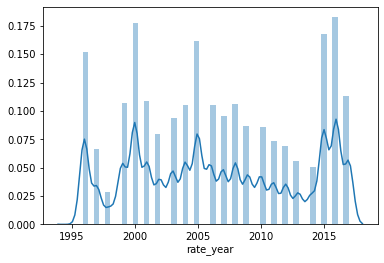

In [18]:
# start to inspcet our data

#moveis meta data
duplications = len(meta_mov_df['id']) - len(meta_mov_df.drop_duplicates(['id']))
print("<<<=== There are %s unique movies in our Data and (%s) Duplications ===>>>" % (len(meta_mov_df['id'].unique()),duplications))
print("\n")
# After inspections in df we found duplicated rows so we'll drop the to keep unique values
meta_mov_df.drop_duplicates(['id'])

# rating_df inspection of rating 
rating_df_sample['date'] = rating_df_sample.apply(lambda x: str(datetime.fromtimestamp(x['timestamp']).strftime('%Y-%m-%d')),axis=1)
rating_df_sample['rate_year'] = rating_df_sample.apply(lambda x: parse(x['date']).year,axis=1)

# dist of year
print('<<<=== lets check out the movies rating years ===>>>')
sns.distplot(rating_df_sample['rate_year'] )

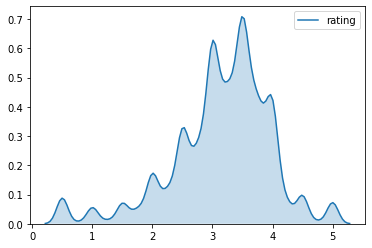

In [19]:
# calulate ratings means distributions
ratings_mean = rating_df_sample.groupby(by=['movieId'])['rating'].mean()
sns.kdeplot(ratings_mean,shade=True)

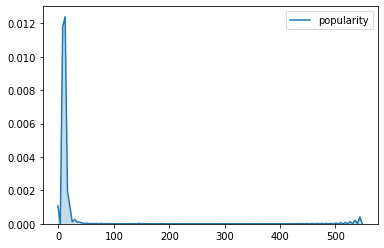

In [20]:
# Now Lets get started to meet meta our Data
meta_mov_df['popularity'] = pd.to_numeric(meta_mov_df['popularity'],errors='coerce')
sns.kdeplot(meta_mov_df['popularity'], shade=True);